In [1]:
#!"./setup-EForecast.sh"

%reload_ext autoreload
%autoreload 2

%matplotlib inline

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from doodahs import doodahs

Using TensorFlow backend.


In [2]:
# Import the different *.csv datasets and add the _state tag to all columns
weather_NSW, electricity_NSW = doodahs.import_n_statelabel('NSW')
weather_QLD, electricity_QLD = doodahs.import_n_statelabel('QLD')
weather_VIC, electricity_VIC = doodahs.import_n_statelabel('VIC')
weather_SA, electricity_SA = doodahs.import_n_statelabel('SA')

In [3]:
# join all electricity data
df_elec = electricity_NSW.join(electricity_QLD)
df_elec = df_elec.join(electricity_VIC)
df_elec = df_elec.join(electricity_SA)
df_elec = doodahs.create_diffs(df_elec, list(range(len(df_elec.columns))))

# outer join for all weather data
df_weather = weather_NSW.join(weather_QLD)
df_weather = df_weather.join(weather_VIC)
df_weather = df_weather.join(weather_SA)
df_weather = doodahs.create_diffs(df_weather, list(range(len(df_weather.columns))))

In [13]:
# re-sort dataset columns and extract test data y
df_elec = df_elec.reindex(sorted(df_elec.columns), axis=1)
y = df_elec.iloc[:,8:12]
for _ in y.columns:
    del df_elec[_]

print('elec shape: ',df_elec.shape)
print('y shape: ',y.shape)

# Create complete dataset of all train variables
df_all = df_weather.join(df_elec)

print('df_all shape: ',df_all.shape)

elec shape:  (445, 12)
y shape:  (445, 4)
df_all shape:  (445, 60)


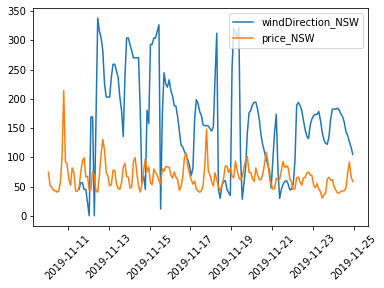

In [4]:
# Plotting of the different variables to look at possible trends in the data:
doodahs.plot_two_vars(weather_NSW, 3,electricity_NSW, 0, start='2019-11-10', end='2019-11-25', onediff=False, twodiff=False)
# No extremely obvious trends found, beyond the day/night periodicity

# After first exploration: 

    -$generated, $d_price, $d_temperature largest feature importance, with and small overlap to correlations ($generated, $d_price, $d_pressure) to $price

    -pairplot confirms corrs, most vars poisson distributed

    -simple linear combinations yield features w/ only slighly improved corr to $price

    -idea: cluster states & weather for extra features?
    -try more combinations between linear combos between different vars of/in different states

    -add features on holidays (look for that old function and time of day/ day of week feature

    -initial elementary feature engineering (-pear['testfeature'] = temp_df.temperature * temp_df.rain_prob * temp_df.wind_speed * temp_df.wind_direction) is in top5 features of 1k tree RF; higher .feature_importance_ are likely for better features

In [14]:
corr_NSW = (df_all.join(y.iloc[:,0])).corr()
corr_QLD = (df_all.join(y.iloc[:,1])).corr()
corr_SA = (df_all.join(y.iloc[:,2])).corr()
corr_VIC = (df_all.join(y.iloc[:,3])).corr()
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# f, ax = plt.subplots(figsize=(11, 9))
# cmap = sns.diverging_palette(230, 0, as_cmap=True)
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# sns.pairplot(corr_df)

In [15]:
# Four highest correlations to the electricity spot prices in NSW:
corr_NSW.price_NSW.sort_values(ascending=False)[1:5]

scheduledGeneration_QLD     0.701307
scheduledGeneration_NSW     0.673093
scheduledGeneration_SA      0.529868
d_scheduledGeneration_SA    0.461980
Name: price_NSW, dtype: float64

In [16]:
# ensure equal shape on both X & Y, so both train and test data share the same timeframe
df_all = df_all.dropna()
y = y[(y.index>=df_all.index[0]) & (y.index<=df_all.index[-1])]
#assert df_all.index == y.index, 'Index differs for df_all and y!'
y.shape

(214, 4)

In [17]:
# Fitting a multivariate linear model to the top i variables with the highest correlation to 'price_NSW':

for i in range(9,10):
    banana = list(corr_NSW.price_NSW.sort_values(ascending=False)[1:i].index)
    training_features = df_all[banana].iloc[0:187,:]

    test_features = y[['price_NSW']].iloc[0:187,:]

    predict_param = df_all[banana].iloc[188:199,:]

    lin1, lin1_pred = doodahs.linear_model_predictions(training_features, test_features, predict_param)

    #test_data = y[['price_NSW']].iloc[169:188,:]
    test_data = y[['price_QLD']].iloc[188:199,:]
    print(i,doodahs.model_MAE(lin1, lin1_pred, test_data,print_result=True))
    print(i,doodahs.rel_error(lin1, lin1_pred, test_data,print_result=True))

The model is inaccurate by $11.63 on average.
9 None
The model has a relative error of 20.9%.
9 None


Best accuracy reached for the 8 highest corr variables

In [18]:
# Fitting a Random Forest to the entire 60 variable dataset, testing for the influence of the train/test split:

for i in range(184,185):
    banana = list(corr_NSW.price_NSW.sort_values(ascending=False)[1:-1].index)
    
    training_features = df_all[banana].iloc[0:i,:]

    test_features = y[['price_NSW']].iloc[0:i,:]

    predict_param = df_all[banana].iloc[(i+1):188,:]

    RFR = RandomForestRegressor(n_estimators=1000, random_state=42)
    RFR.fit(training_features,np.ravel(test_features))
    RFR_pred = RFR.predict(predict_param)

    #test_data = y[['price_NSW']].iloc[(i+1):188,:]
    test_data = y[['price_VIC']].iloc[(i+1):188,:]
    print(i,doodahs.model_MAE(RFR, RFR_pred.reshape((len(RFR_pred),1)), test_data,print_result=True))
    print(i,doodahs.rel_error(RFR, RFR_pred.reshape((len(RFR_pred),1)), test_data,print_result=True))

The model is inaccurate by $3.44 on average.
184 None
The model has a relative error of 5.47%.
184 None


In [12]:
# RFR.feature_importances_

# apple = pd.DataFrame()
# apple['feature'] = [*temp_df.iloc[:,1:16].columns]#,'testfeature']
# apple['importance'] = [*RFR.feature_importances_]
# apple.sort_values(by=['importance'], ascending=False)

# After second day am-sesh:

   -including data from all states extemely interesting. 
    E.g. scheduledGeneration_QLD has highest corr to price_NSW - different states!!!

    -excluding np.nan there are still ~200rows, 60 correlations

# EOD:

    -RF power increases dramatically the closer to the end of dataset we get 
    -RF efficacy hovers around ~10% rel acc, even predicting for other states
    after training on NSW price movements
    -linear model (9 highest corr to price_NSW) yields dramatically better
    results in the single digits rel err
    -RF shows that, e.g., the best features to predict prices in
    QLD are the scheduledGeneration_QLD, and scheduledGeneration_NSW,
    accounting for the im-/export of energy? (actually, it also comes
    down to these to to predict prices for SA)


In [19]:
# split dates into year month day day of week hour, etc for additional features 
df_all = doodahs.split_dates_df(df_all,)

# and this is what the new cols look like
# df_all.iloc[:,-7:-1].head(1)

In [20]:
# Fitting a Random Forest to the entire 60 variable dataset, testing for the influence of the train/test split:

for i in range(184,185):
    training_features = df_all[list(corr_NSW.price_NSW.sort_values(ascending=False)[1:-1].index)].iloc[0:i,:]

    test_features = y[['price_NSW']].iloc[0:i,:]

    predict_param = df_all[list(corr_NSW.price_NSW.sort_values(ascending=False)[1:-1].index)].iloc[(i+1):188,:]

    RFR = RandomForestRegressor(n_estimators=1000, random_state=42)
    RFR.fit(training_features,np.ravel(test_features))
    RFR_pred = RFR.predict(predict_param)

    #test_data = y[['price_NSW']].iloc[(i+1):188,:]
    test_data = y[['price_VIC']].iloc[(i+1):188,:]
    print(i,doodahs.model_MAE(RFR, RFR_pred.reshape((len(RFR_pred),1)), test_data,print_result=True))
    print(i,doodahs.rel_error(RFR, RFR_pred.reshape((len(RFR_pred),1)), test_data,print_result=True))

The model is inaccurate by $3.44 on average.
184 None
The model has a relative error of 5.47%.
184 None


# Some improvement, not great though.

Next step will be to hard code the time difference, shifting the price column by 1,2,3,...,n timesteps  

In [21]:
# data is binned in 2h timesteps thus the following shifts:
y_2h = doodahs.time_shift(y, 1)
y_2h.name = 1
y_6h = doodahs.time_shift(y, 3)
y_6h.name = 3
y_12h = doodahs.time_shift(y, 6)
y_12h.name = 6
y_24h = doodahs.time_shift(y, 12)
y_24h.name = 12
y_timeshift = [y_2h, y_6h, y_12h, y_24h]

In [22]:
# Fitting a Random Forest to the entire 60 variable dataset, testing for the influence of the train/test split:

for _a in y_timeshift:
    training_features = df_all.iloc[0:180,:]

    test_features = _a[['price_NSW']].iloc[0:180,:]

    predict_param = df_all.iloc[(181):188,:]

    RFR = RandomForestRegressor(n_estimators=1000, random_state=42)
    RFR.fit(training_features,np.ravel(test_features))
    RFR_pred = RFR.predict(predict_param)

    #shift = _a.name
    test_data = _a[['price_SA']].iloc[(181):188,:]
    print(_a.name,doodahs.model_MAE(RFR, RFR_pred.reshape((len(RFR_pred),1)), test_data,print_result=True))
    print(_a.name,doodahs.rel_error(RFR, RFR_pred.reshape((len(RFR_pred),1)), test_data,print_result=True))

The model is inaccurate by $8.76 on average.
1 None
The model has a relative error of 13.3%.
1 None
The model is inaccurate by $27.45 on average.
3 None
The model has a relative error of 1.46e+02%.
3 None
The model is inaccurate by $63.91 on average.
6 None
The model has a relative error of 1.17e+03%.
6 None
The model is inaccurate by $12.13 on average.
12 None
The model has a relative error of 20.1%.
12 None


Absolutely Rubbish, the accuracy yielded is atrocious.

keras.preprocessing.sequence.TimeseriesGenerator(data, targets, length, sampling_rate=1, stride=1, start_index=0, end_index=None, shuffle=False, reverse=False, batch_size=128)


In [23]:
df_NSW = df_all[['temperature_NSW', 'rainProb_NSW', 'windSpeed_NSW', 'windDirection_NSW','cloudCover_NSW', 'pressure_NSW','d_temperature_NSW', 'd_rainProb_NSW', 'd_windSpeed_NSW','d_windDirection_NSW','d_cloudCover_NSW', 'd_pressure_NSW','d_price_NSW','d_scheduledGeneration_NSW','scheduledGeneration_NSW','year', 'month', 'day', 'dayofweek','dayofyear', 'is_quarter_end', 'hour']]

df_QLD = df_all[['temperature_QLD', 'rainProb_QLD', 'windSpeed_QLD', 'windDirection_QLD','cloudCover_QLD', 'pressure_QLD','d_temperature_QLD', 'd_rainProb_QLD', 'd_windSpeed_QLD','d_windDirection_QLD','d_cloudCover_QLD', 'd_pressure_QLD','d_price_QLD','d_scheduledGeneration_QLD','scheduledGeneration_QLD','year', 'month', 'day', 'dayofweek','dayofyear', 'is_quarter_end', 'hour']]

df_VIC = df_all[['temperature_VIC', 'rainProb_VIC', 'windSpeed_VIC', 'windDirection_VIC','cloudCover_VIC', 'pressure_VIC','d_temperature_VIC', 'd_rainProb_VIC', 'd_windSpeed_VIC','d_windDirection_VIC','d_cloudCover_VIC', 'd_pressure_VIC','d_price_VIC','d_scheduledGeneration_VIC','scheduledGeneration_VIC','year', 'month', 'day', 'dayofweek','dayofyear', 'is_quarter_end', 'hour']]

df_SA = df_all[['temperature_SA', 'rainProb_SA', 'windSpeed_SA', 'windDirection_SA','cloudCover_SA', 'pressure_SA','d_temperature_SA', 'd_rainProb_SA', 'd_windSpeed_SA','d_windDirection_SA','d_cloudCover_SA', 'd_pressure_SA','d_price_SA','d_scheduledGeneration_SA','scheduledGeneration_SA','year', 'month', 'day', 'dayofweek','dayofyear', 'is_quarter_end', 'hour']]

In [24]:
print(df_VIC.shape,df_QLD.shape,df_NSW.shape,df_SA.shape)

(214, 22) (214, 22) (214, 22) (214, 22)


In [27]:
import tensorflow as tf
from keras.layers import Input, Dense, concatenate, LeakyReLU
from keras.layers import Reshape
from keras.models import Model
from keras.preprocessing.sequence import TimeseriesGenerator

# first linear NN model:
banana = list(corr_NSW.price_NSW.sort_values(ascending=False)[1:9].index)
training_features = df_all[banana].iloc[0:201,:]
test_features = y[['price_NSW']].iloc[0:201,:]
predict_param = df_all[banana].iloc[202:213,:]

input_size = training_features.shape[1]
inputs = Input(shape=(input_size,))

Dense1 = Dense(1, use_bias=True, kernel_initializer='normal', activation='linear')(inputs)

model_lin_tf = Model(input= inputs, output = Dense1)
model_lin_tf.compile(loss='mse', optimizer='adam')

history = model_lin_tf.fit(training_features, test_features, epochs=10)

doodahs.model_MAE(model_lin_tf, model_lin_tf.predict(predict_param),y[['price_NSW']].iloc[188:199,:], print_result=True)
doodahs.rel_error(model_lin_tf, model_lin_tf.predict(predict_param),y[['price_NSW']].iloc[188:199,:], print_result=True)

# import matplotlib.pyplot as plt
# plt.plot(history.history['loss'])

/Users/markusdollmann/anaconda3/envs/EFORECAST/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
Epoch 1/10
201/201 [==============================] - 0s 2ms/step - loss: 9266.8036
Epoch 2/10
201/201 [==============================] - 0s 37us/step - loss: 856.6569
Epoch 3/10
201/201 [==============================] - 0s 34us/step - loss: 1497.7783
Epoch 4/10
201/201 [==============================] - 0s 37us/step - loss: 1049.4466
Epoch 5/10
201/201 [==============================] - 0s 34us/step - loss: 437.2360
Epoch 6/10
201/201 [==============================] - 0s 41us/step - loss: 605.4468
Epoch 7/10
201/201 [==============================] - 0s 36us/step - loss: 444.1852
Epoch 8/10
201/201 [==============================] - 0s 37us/step - loss: 431.8638
Epoch 9/10
201/201 [==============================] - 0s 34us/step - loss: 402.1540
Epoch 10/10
201/201 [=========

# Random Thoughts

keras.preprocessing.sequence.TimeseriesGenerator(data, targets, length, sampling_rate=1, stride=1, start_index=0, end_index=None, shuffle=False, reverse=False, batch_size=128)

length=12? implies one day, neglects these interactions?

In [54]:
model_CNN = doodahs.func_CNN_1(df_QLD, nn_name='model_CNN')
model_CNN.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

/Users/markusdollmann/Desktop/ElectricityForecast/1_modules/doodahs/doodahs.py:267: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="model_CNN", inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  


In [65]:
#model_CNN.summary()

In [94]:
import time
batch_size = 24
epochs = 500
start_time = time.time()
NSW = doodahs.reshape_for_CNN(df_NSW)
QLD = doodahs.reshape_for_CNN(df_QLD)
VIC = doodahs.reshape_for_CNN(df_VIC)
SA = doodahs.reshape_for_CNN(df_SA)

# This model optimises for the mse for all four states to be minimal:
history = model_CNN.fit([NSW[0:200,:], QLD[0:200,:], VIC[0:200,:], SA[0:200,:]], y.iloc[0:200,:],
          batch_size=batch_size,
          epochs=epochs,
          verbose=0)

print("--- {} seconds passed ---".format(time.time() - start_time))

# score = model_CNN.evaluate([NSW[201:213,:], QLD[201:213,:], VIC[201:213,:], SA[201:213,:]], y.iloc[201:213,:], verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

predictions = model_CNN.predict([NSW[201:213,:], QLD[201:213,:], VIC[201:213,:], SA[201:213,:]])

--- 37.29268789291382 seconds passed ---


In [95]:
mae, rel = doodahs.MAE_CNN(model_CNN, [NSW[201:213,:], QLD[201:213,:], VIC[201:213,:], SA[201:213,:]], y.iloc[201:213,:])
print('--- MAE of\n {0},\n\nwith a relative error of\n{1} ---'.format(mae, rel))

--- MAE of
 price_NSW    13.244
price_QLD    14.100
price_SA     27.830
price_VIC    19.073
dtype: float64,

with a relative error of
price_NSW     17.875
price_QLD     20.494
price_SA     127.384
price_VIC     23.948
dtype: float64 ---


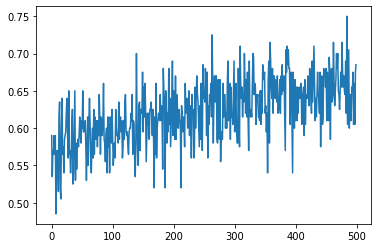

In [100]:
#plt.plot(history.history['loss'])
plt.plot(history.history['acc'])

In [51]:
#reshap = Reshape((Layer.shape[1], 1), input_shape=(X.shape[1], ))(layer)
model.fit_generator()

112

In [ ]:
# the way it is set up, len(TimeseriesGenerator)= (len(data)-length)/batch_size, thus for #epochs>=6 and len(data)=190, length=16 and batch_size=29
# to calculate a good number of batches/epoch, use floor(#samples/batch_size), to avoid seeing datapoints multiple times during a single epoch

# DataGen_NSW = TimeseriesGenerator(df_all, y, 16, sampling_rate=1, stride=1, shuffle=False, reverse=False, batch_size=29)

,price_NSW,price_QLD,price_SA,price_VIC
2019-11-11 15:00:00,73.902058,42.191511,-188.904570,74.399059
2019-11-11 17:00:00,93.971053,86.783147,9.616821,91.430584
2019-11-11 19:00:00,99.080228,106.321299,86.391360,90.160702


In [50]:
arr_ = np.array([[0,1,2,3],['a','b','c','d']])
nrows, ncols = arr_.shape
print(arr_.shape)
arr_.reshape(nrows, ncols, 1)

(2, 4)


array([[['0'],
        ['1'],
        ['2'],
        ['3']],

       [['a'],
        ['b'],
        ['c'],
        ['d']]], dtype='<U21')

,price_NSW,price_QLD,price_SA,price_VIC
2019-11-11 15:00:00,73.902058,42.191511,-188.904570,74.399059
2019-11-11 17:00:00,93.971053,86.783147,9.616821,91.430584
2019-11-11 19:00:00,99.080228,106.321299,86.391360,90.160702


In [35]:
a = a.reshape((a.shape[0], a.shape[1], 1))

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [48]:
y_24h.name = 12

In [51]:
y_24h.name = 12
y_timeshift = [y_2h, y_6h, y_12h, y_24h]

In [52]:
weather_NSW, electricity_NSW = doodahs.import_n_statelabel('NSW')
weather_QLD, electricity_QLD = doodahs.import_n_statelabel('QLD')
weather_VIC, electricity_VIC = doodahs.import_n_statelabel('VIC')
weather_SA, electricity_SA = doodahs.import_n_statelabel('SA')

# join all data state wise
df_NSW = weather_NSW.join(electricity_NSW['scheduledGeneration_NSW'])
df_NSW = doodahs.create_diffs(df_NSW, list(range(len(df_NSW.columns))))
df_QLD = weather_QLD.join(electricity_QLD['scheduledGeneration_QLD'])
df_QLD = doodahs.create_diffs(df_QLD, list(range(len(df_QLD.columns))))
df_VIC = weather_VIC.join(electricity_VIC['scheduledGeneration_VIC'])
df_VIC = doodahs.create_diffs(df_VIC, list(range(len(df_VIC.columns))))
df_SA = weather_SA.join(electricity_SA['scheduledGeneration_SA'])
df_SA = doodahs.create_diffs(df_SA, list(range(len(df_SA.columns))))

y_nn = electricity_NSW.join(electricity_QLD['price_QLD'])
del y_nn['scheduledGeneration_NSW']
y_nn = y_nn.join(electricity_VIC['price_VIC'])
y_nn = y_nn.join(electricity_SA['price_SA'])

print('NSW', df_NSW.shape)   
print('QLD', df_QLD.shape)
print('VIC', df_VIC.shape)   
print('SA', df_SA.shape)       
df_NSW = df_NSW.dropna()
df_QLD = df_QLD.dropna()
df_VIC = df_VIC.dropna()
df_SA = df_SA.dropna()



y_nn = y_nn[(y_nn.index>=df_NSW.index[0])&(y_nn.index<=df_NSW.index[-1])]
assert y_nn.shape[0]==df_NSW.shape[0], 'Different columns lengths detected!'
print('data x shape: ',df_NSW.shape)
print('test y shape: ',y_nn.shape)

[                     price_NSW   price_QLD   price_SA  price_VIC
 2019-11-11 15:00:00  93.971053   86.783147   9.616821  91.430584
 2019-11-11 17:00:00  99.080228  106.321299  86.391360  90.160702
 2019-11-11 19:00:00  66.364615   64.227690  58.054220  61.840291
 2019-11-11 21:00:00  67.524743   64.960000  59.524424  65.541250
 2019-11-11 23:00:00  43.994170   43.253505  37.627617  40.739793
 ...                        ...         ...        ...        ...
 2019-11-27 19:00:00  60.811630   60.686921  66.382507  64.112951
 2019-11-27 21:00:00  48.882500   49.116166  57.240443  52.753398
 2019-11-27 23:00:00  41.057230   39.586084  47.445475  43.007240
 2019-11-28 01:00:00  38.420000   37.423622  41.511857  37.506012
 2019-11-28 03:00:00        NaN         NaN        NaN        NaN
 
 [199 rows x 4 columns],
                      price_NSW  price_QLD   price_SA  price_VIC
 2019-11-11 15:00:00  66.364615  64.227690  58.054220  61.840291
 2019-11-11 17:00:00  67.524743  64.960000  59.5244